In [58]:
# First let's download our data
import math
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch



In [59]:
# Fetch events for the specified match
df = sb.events(match_id=3869685).sort_values(by=['index'])

# Remove any data from penalty shootouts (period >= 5)
df = df[df['period'] < 5]

# Display the first few rows of the dataframe
df.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...",Argentina,779,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",France,771,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,France,771,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Argentina,779,00:00:00.000,Half Start,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,France,771,00:00:00.578,Pass,NaN


In [60]:
# Split the data into two teams
team1 = df[df.team == 'Argentina']
team2 = df[df.team == 'France']


In [61]:
# Set a couple of constants for the colors
FRANCE_COLOR = '#002654'
ARGENTINA_COLOR = '#43A1D5'
ARGENTINA_TEAM_ID = 779
FRANCE_TEAM_ID = 771

In [80]:
# function to create a shot map for a team
#def create_shotmap(team, ax):
def create_shotmap(df, ax):
    pitch = VerticalPitch(pitch_type='statsbomb', half=True)
    pitch.draw(ax=ax)
    
    # the shots data is in the 'type' column
    #team = team[team['type']=='Shot']
    df = df[df['type'] == 'Shot']
    # Sort the values so they are in order of time
    df = df.sort_values(by="index")
    #  Keep relevant columns
   # team = team[['team', 'player', 'location', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type']]
    df = df[['team', 'player', 'location', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type']]

    
   
    # Split location into x and y coordinates
    df[['x', 'y']] = df['location'].apply(pd.Series)
    



    
    # Draw the shotmap
    for x in df.to_dict(orient='records'):
    
        pitch.scatter(
            x=x['x'], y=x['y'], ax=ax, 
            s=500 * x['shot_statsbomb_xg'], 
            color='green' if x['shot_outcome'] == 'Goal' else 'white', 
            edgecolors='black', alpha=0.7
        )

In [85]:
# Function to create a pass network for a team

def create_passnetwork(df, ax):
    df[['x', 'y']] = df['location'].apply(pd.Series)
    
    # Extract tactics
    tactics = df[~df['tactics'].isnull()][['tactics', 'team']]
    all_jersey_numbers = []
    
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Make a new, single column for time and sort the events in chronological order

    df["newsecond"] = 60 * df["minute"] + df["second"]
    df.sort_values(by=['newsecond'])
    
    # identify the passer and then the recipient, who'll be the playerId of the next action
  
    df['passer'] = df['player_id']
    df['recipient'] = df['passer'].shift(-1)

    
    # filter for only passes and then successful passes
    passes_df = df.loc[(df['type']=="Pass")]
    passes_df.loc[:, 'pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
    
    #find time of the team's first substitution and filter the df to only passes before that
    sub_df = df.loc[(df['type'] == "Substitution")]
    first_sub = sub_df["newsecond"].min()
    first_sub = max(first_sub, 60 * 45)
    #if first_sub <= (60 * 45):
     #   first_sub = 60 * 45
    
    # Filter completions to before the first substitution
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # calculating average locations and counts
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
    average_locs_and_count.columns = ['x', 'y', 'count']
    
    #counting passes between players
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )
    
    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
    #function to plot pass lines
    def pass_line_template(ax, x, y, end_x, end_y, line_color):
        ax.annotate(
            '', xy=(end_y,  end_x),xytext=(y, x),
            zorder=1, arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
        )
        
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y-y, end_x-x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    pitch = VerticalPitch(pitch_type='statsbomb')
    pitch.draw(ax=ax)
    
    
    # Plot arrows for passes
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
    # plot nodes
    pitch.scatter(
        average_locs_and_count.x, average_locs_and_count.y, s=500,
        color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
    )
    
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(
            jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
            xy=(row.x, row.y),
            c='#132743',
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=ax
        )

In [86]:
# Function to create a summary table for both teams
def create_table(team1, team2):
    # Drop rows where the pass_outcome is Unknown
    team1 = team1[team1['pass_outcome'] != 'Unknown']
    team2 = team2[team2['pass_outcome'] != 'Unknown']
    
    # Create a table with the data
    # We first need to calculate the statistics for each team
    # we will calcualte the following stats:
    # - goals
    # - xG
    # - shots
    # - shots on target
    # - passes
    # - pass completion %
    
    # Create a dictionary to store the stats
    stats = {
        'goals': {'team1': len(team1[team1['type'] == 'Goal']), 'team2': len(team2[team2['type'] == 'Goal'])},
        'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
        'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
        'shots_on_target': {
            'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
            'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
        },
        'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
        'pass_completion': {
            'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
            'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
        }
    }
    
    # store as a dataframe
    stats_df = pd.DataFrame(stats).T

    column_labels = ['', '', '']
    table_vals = [
        [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
        [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
        [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
        [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
        [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
    ]
    
    return column_labels, table_vals

In [87]:
# Sample function to create a flow chart for cumulative xG
def create_xg_flow_chart(df, ax):
    # We'll use the original df instead of the team1 and team2 dataframes
    
    # Filter the columns to only shots
    df = df[df['type'] == 'Shot']
    
    # Sort the values so they are in order of time
    df = df.sort_values(by="index")
    
    # Calculate the cumulative xG for each team
    df['cumulative_xG'] = df.groupby('team_id')['shot_statsbomb_xg'].cumsum()
    
    # Plot the xG for each team by half
    # We want to make it so the lines both start at 0
    for team in df['team_id'].unique():
        
        team_df = df[df['team_id'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({
            'team_id': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': None, 'cumulative_xG': 0, 'period': 1
        }, index=[0]), team_df])
        
        ax.plot(
            team_df['minute'], 
            team_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=ARGENTINA_COLOR if team == ARGENTINA_TEAM_ID else FRANCE_COLOR
        )   
            
    
    # We Can add a scatter plot to show the goals
    for team in df['team_id'].unique():
        team_df = df[(df['team_id'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
        for x in team_df:
            ax.scatter(
                x['minute'], 
                x['cumulative_xG'], 
                c='white',
                edgecolor=ARGENTINA_COLOR if team == ARGENTINA_TEAM_ID else FRANCE_COLOR,
                s=100,
                # We want the goals to be on top of the lines
                zorder=5
            )
            
            # add a label to the goals for the player who scored
            ax.text(
                x['minute'], 
                x['cumulative_xG'] - .07, 
                x['player'], 
                ha='center', 
                va='center', 
                fontfamily='monospace', 
                fontsize=8,
                zorder=10
            )
            
    # Let's label the x axis with first and second half
    ax.set_xticks([0, 45, 90, 120])
    ax.set_xticklabels(['0\'', '45\'', '90\'', '120\''])
    
    # Let's get rid of the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [94]:
# Create DataFrame
df = pd.DataFrame(df)

# Check the structure of the 'location' column
print("Location Data:", df['location'].tolist())

#Ensure that the location is in the correct format
if df['location'].apply(lambda x: isinstance(x, (list, tuple)) and len(x) == 2).all():
    # Using .loc to avoid SettingWithCopyWarning
    # Unpack the 'location' column into 'x' and 'y'
    df[['x', 'y']] = pd.DataFrame(df['location'].tolist(), index=df.index)
else:
    print("Error: Not all entries in 'location' are tuples or lists with two elements.")

# Create a new column 'newsecond'
df.loc[:, "newsecond"] = 60 * df["minute"] + df["second"]  # Create newsecond column

# Assign player_id to passer
df.loc[:, 'passer'] = df['player_id']  # Assign player_id to passer

# Assign the next player_id to recipient
df.loc[:, 'recipient'] = df['passer'].shift(-1)  # Shift passer to get recipient


Location Data: [nan, nan, nan, nan, [61.0, 40.1], [48.0, 43.2], [48.0, 43.2], [49.7, 43.6], [92.7, 11.7], [22.7, 80.0], [84.5, 8.5], [36.0, 75.2], [36.0, 75.2], [84.7, 4.7], [35.4, 75.4], [41.1, 73.9], [23.2, 62.8], [23.2, 62.8], [24.7, 59.4], [21.5, 32.2], [21.5, 32.2], [24.0, 27.1], [21.7, 49.3], [21.7, 49.3], [22.1, 49.8], [24.0, 27.3], [24.0, 27.3], [21.7, 24.5], [87.3, 73.5], [26.6, 3.1], [26.6, 3.1], [29.2, 2.5], [73.6, 73.5], [45.6, 4.2], [45.6, 4.2], [75.1, 76.3], [45.0, 3.8], [44.1, 3.8], [20.8, 11.9], [21.7, 17.7], [19.7, 33.3], [19.7, 33.3], [30.9, 42.5], [27.9, 22.6], [27.9, 22.6], [29.8, 29.2], [27.0, 45.9], [27.0, 45.9], [32.1, 54.5], [25.9, 31.6], [25.9, 31.6], [24.7, 29.0], [5.6, 42.3], [5.6, 42.3], [109.3, 37.0], [3.9, 43.4], [67.0, 7.2], [67.0, 7.2], [48.2, 70.7], [49.3, 72.4], [68.5, 5.7], [72.1, 13.4], [72.1, 13.4], [72.3, 13.4], [73.6, 4.7], [73.6, 4.7], [44.9, 72.3], [73.2, 4.0], [58.2, 74.4], [61.9, 5.7], [61.2, 7.0], [44.1, 37.4], [44.1, 37.4], [53.1, 44.9], [45

(-4.0, 84.0, 56.0, 124.0)

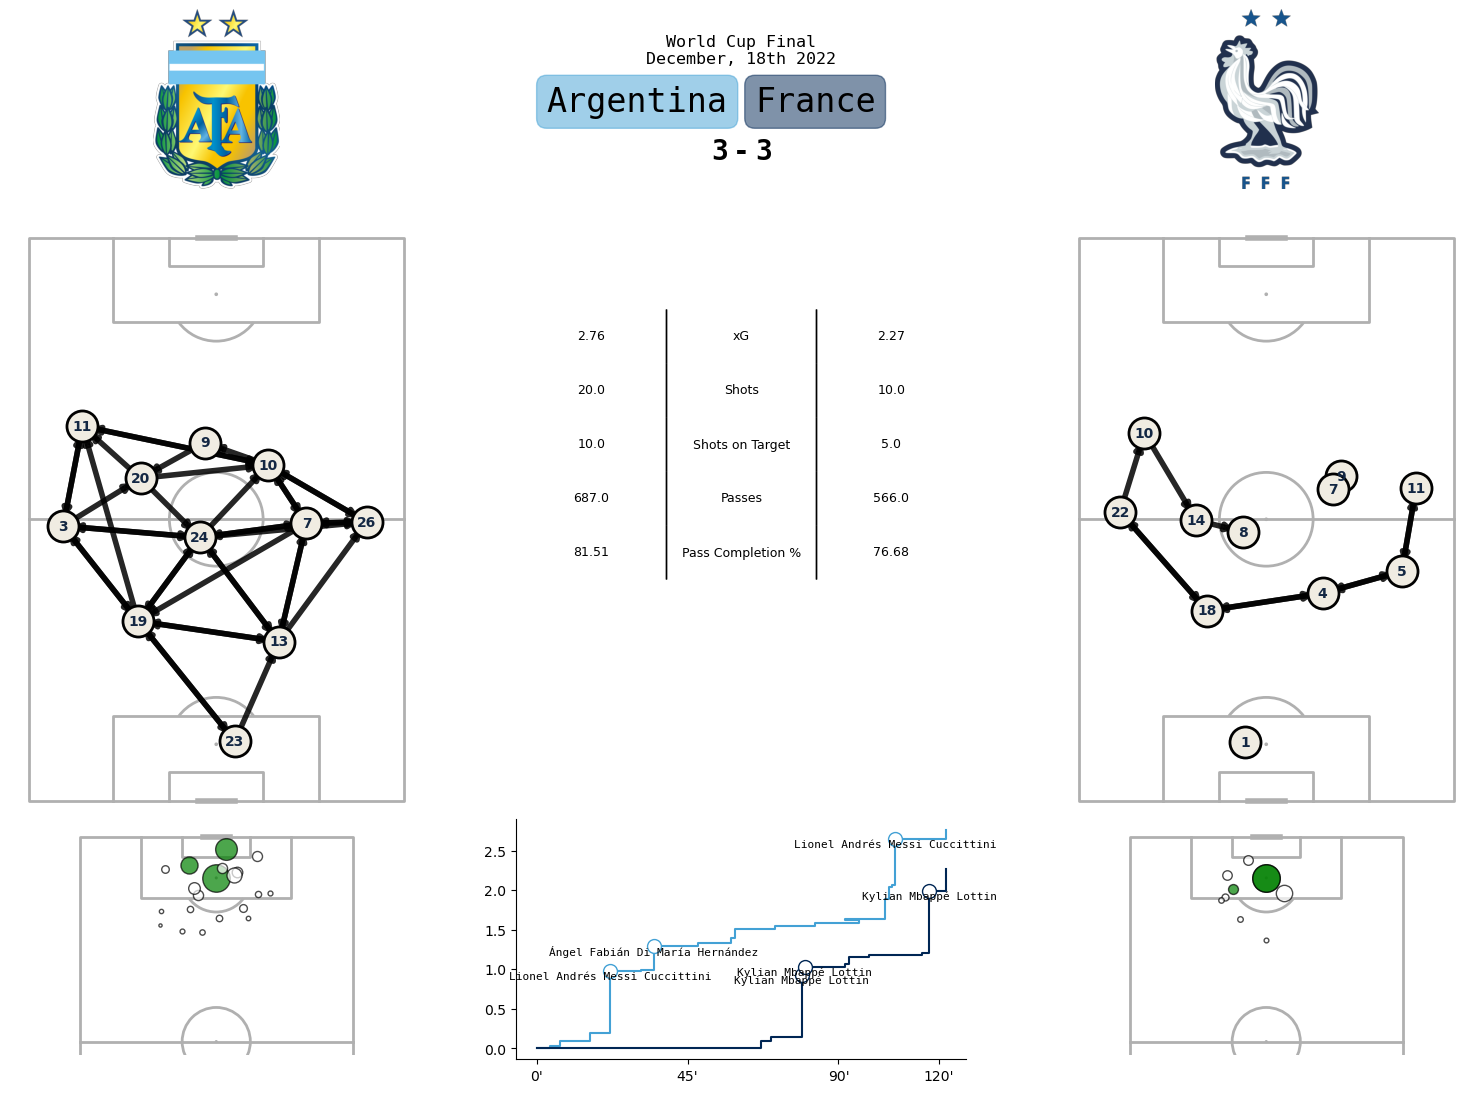

In [91]:
# Set up the figure and grid layout
fig = plt.figure(figsize=(15, 12))

# Top row for the team names and score
# [left, bottom, width, height]

ax1 = fig.add_axes([0.225, 0.775, 0.15, 0.15])

# get the image from the team_logos folder
team1_img = Image.open('argentina_logo.png')
ax1.imshow(team1_img)
ax1.axis('off')

ax2 = fig.add_axes([0.5, 0.8, 0.3, 0.1])
ax2.text(0.5, 0.8, 'World Cup Final\nDecember, 18th 2022', fontsize=12, ha='center', fontdict={'family': 'monospace'})

team_1_text = ax2.text(0.47, .4, 'Argentina', fontsize=24, ha='right', fontdict={'family': 'monospace'})
team_1_text.set_bbox(dict(facecolor='#43A1D5', alpha=0.5, edgecolor='#43A1D5', boxstyle='round'))


team_2_text = ax2.text(0.53, .4, 'France', fontsize=24, ha='left', fontdict={'family': 'monospace'})
team_2_text.set_bbox(dict(facecolor='#002654', alpha=0.5, edgecolor='#002654', boxstyle='round'))

ax2.text(0.47, 0, '3', fontsize=20, ha='right', fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(0.5, 0, '-', fontsize=20, ha='center', fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(0.53, 0, '3', fontsize=20, ha='left', fontdict={'family': 'monospace', 'weight': 'bold'})

ax2.axis('off')

ax3 = fig.add_axes([0.925, 0.775, 0.15, 0.15])
# get the image from the team_logos folder
team2_img = Image.open('france_logo.png')
ax3.imshow(team2_img)
ax3.axis('off')


# ax4 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_axes([0.15, 0.25, 0.3, 0.5])
create_passnetwork(team1, ax4)
ax4.axis('off')

ax5 = fig.add_axes([0.5, 0.2, 0.3, 0.5])
# create a table with data. The middle column will be the statistic with the left and right columns being the stats for each team
column_labels, table_vals = create_table(team1, team2)

table = ax5.table(
    cellText=table_vals, 
    cellLoc='center', 
    edges='vertical',
    bbox=[0, .5, 1, .45],
)

table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if j == 0:
        table.get_celld()[(i, j)].visible_edges = 'R'
    elif j == 2:
        table.get_celld()[(i, j)].visible_edges = 'L'
    else:
        table.get_celld()[(i, j)].visible_edges = 'LR'

ax5.axis('off')

ax6 = fig.add_axes([0.85, 0.25, 0.3, 0.5])
create_passnetwork(team2, ax6)
# ax6.axis('off')

ax7 = fig.add_axes([0.2, 0.05, 0.2, 0.2])
create_shotmap(team1, ax7)
# ax7.axis('off')

ax8 = fig.add_axes([0.5, 0.05, 0.3, 0.2])
create_xg_flow_chart(df, ax8)
# ax8.axis('off')

ax9 = fig.add_axes([0.9, 0.05, 0.2, 0.2])
create_shotmap(team2, ax9)
ax9.axis('off')

In [89]:
# save the figure
fig.savefig('test_example.png', dpi=300, bbox_inches='tight')